In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy

import os
import xml.etree.ElementTree as ET
# from difflib import SequenceMatcher
import PyPDF2
from lxml import etree
# import Levenshtein

# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
import re

# Read papers CSVs

If there is **no** CSV with the downloaded files, use this:

In [7]:
directory = '../phys'
 
tei_files  = dict()
for filename in os.listdir(directory):
    fid = filename[:-6] # must get rid of version value and extensions
    fid = fid.replace('_', '/')
    if fid not in tei_files:
        tei_files[fid] = 0
    tei_files[fid] = tei_files[fid] + 1
    
phys_papers = pd.read_csv('phys_papers.csv', dtype = {'id': str}, parse_dates = ['date']).query('id in @tei_files').reset_index(drop = True)

If there is CSV:

In [126]:
cs_papers = pd.read_csv('../final_cs_papers.csv', dtype = {'id': str}, parse_dates = ['date'])

In [127]:
math_papers = pd.read_csv('../final_math_papers.csv', dtype = {'id': str}, parse_dates = ['date'])

In [128]:
phys_papers = pd.read_csv('../final_phys_papers.csv', dtype = {'id': str}, parse_dates = ['date'])

# Functions

In [24]:
def get_pages_cnt(papers, input_path):
    pages = []
    is_pdf = []

    for index, row in papers.iterrows():
        path = input_path + str(row.id).replace('/', '_') + 'v' + str(row.version) + '.pdf'
        file = open(path, 'rb')
        try:
            readpdf = PyPDF2.PdfFileReader(file, strict=False)
            pages.append(readpdf.numPages)
            is_pdf.append(True)
        except Exception as e:
            print(row.id, ' ', e)
            pages.append(np.nan)
            is_pdf.append(False)
    return pages, is_pdf

In [704]:
def get_xml_info(papers, xml_path):
    namespace = '{http://www.tei-c.org/ns/1.0}'
    analytic_path = './{0}teiHeader/{0}fileDesc/{0}sourceDesc/{0}biblStruct/{0}analytic'.format(namespace)
    figures_path = './{0}text/{0}body/{0}figure'.format(namespace)
    
    ref_cnt = []
    authors_cnt = []
    figs_cnt = []
    titles = []
    grobid = []
    for index, row in papers.iterrows():        
        if not row.is_pdf:
            grobid.append(False)
            ref_cnt.append(np.nan)
            authors_cnt.append(np.nan)
            figs_cnt.append(np.nan)
            titles.append(row.title)
            continue
        try:
            tree = etree.parse(xml_path + str(row.id).replace('/', '_') + 'v' + str(row.version) + '.tei.xml')
            root = tree.getroot()
            
            grobid.append(True)
            
            e = root.find(analytic_path)
            authors = e.findall('.//{0}persName'.format(namespace))
            ref = root.find('.//{0}listBibl'.format(namespace))
            figs = root.findall(figures_path)
            title = root.find('./{0}teiHeader//{0}title'.format(namespace))

            if ref is not None:
                ref_cnt.append(len(ref))
            else:
                ref_cnt.append(np.nan)

            if authors is not None and len(authors) > 0:
                authors_cnt.append(len(authors))
            else:
                authors_cnt.append(np.nan)

            if figs is not None:
                figs_cnt.append(len(figs))
            else:
                figs_cnt.append(np.nan)

            if title is not None and title.text is not None:
                titles.append(title.text)
            else:
                titles.append(row.title)
                
        except Exception as e:
            ref_cnt.append(np.nan)
            authors_cnt.append(np.nan)
            figs_cnt.append(np.nan)
            titles.append(row.title)
            grobid.append(False)
        
    return grobid, ref_cnt, authors_cnt, figs_cnt, titles

In [317]:
def get_words_cnt(papers, xml_path):
    namespace = '{http://www.tei-c.org/ns/1.0}'
    sub_pattern = regex.compile(r'<.*?>')
    find_pattern = regex.compile(r'\p{L}\p{L}+')
    
    words_cnt = []
    tokens_cnt = []
    for index, row in papers.iterrows():        
        if (not row.is_pdf) or (not row.grobid):
            words_cnt.append(np.nan)
            tokens_cnt.append(np.nan)
            continue
        
        tree = etree.parse(xml_path + str(row.id).replace('/', '_') + 'v' + str(row.version) + '.tei.xml')
        root = tree.getroot()
        curr_text = root.find('./{0}text'.format(namespace))
        
        if curr_text is not None:
            text = str(etree.tostring(curr_text)).lower()
            text = sub_pattern.sub('', text)
            
            words = find_pattern.findall(text)
            curr_dict = set(words)
            
            words_cnt.append(len(curr_dict))
            tokens_cnt.append(len(words))
        else:
            words_cnt.append(np.nan)
            tokens_cnt.append(np.nan)
        
    return words_cnt, tokens_cnt

In [331]:
def get_text_modification(papers, xml_path):
    namespace = '{http://www.tei-c.org/ns/1.0}'
    sub_pattern = regex.compile(r'<.*?>')
    find_pattern = regex.compile(r'\p{L}\p{L}+')
    
    added_words_cnt = []
    removed_words_cnt = []
    for index, row in papers.iterrows():        
        if row.version == 1 or (not row.is_pdf) or (not row.grobid):
            added_words_cnt.append(np.nan)
            removed_words_cnt.append(np.nan)
            continue
    
        prev_vers = papers.loc[(papers.id == row.id) & (papers.version == row.version - 1)].iloc[0]
        if (not prev_vers.is_pdf) or (not prev_vers.grobid):
            added_words_cnt.append(np.nan)
            removed_words_cnt.append(np.nan)
            continue
        
        tree = etree.parse(xml_path + str(row.id).replace('/', '_') + 'v' + str(row.version) + '.tei.xml')
        root = tree.getroot()
        curr_text = root.find('./{0}text'.format(namespace))
        
        tree = etree.parse(xml_path + str(row.id).replace('/', '_') + 'v' + str(row.version - 1) + '.tei.xml')
        root = tree.getroot()
        prev_text = root.find('./{0}text'.format(namespace))
        
        if curr_text is not None and prev_text is not None:
            text = str(etree.tostring(curr_text)).lower()
            text = sub_pattern.sub('', text)
            words = find_pattern.findall(text)
            curr_dict = set(words)
            
            text = str(etree.tostring(prev_text)).lower()
            text = sub_pattern.sub('', text)
            words = find_pattern.findall(text)
            prev_dict = set(words)
            
            added_words_cnt.append(len(curr_dict.difference(prev_dict)))
            removed_words_cnt.append(len(prev_dict.difference(curr_dict)))
        else:
            added_words_cnt.append(np.nan)
            removed_words_cnt.append(np.nan)
        
    return added_words_cnt, removed_words_cnt

In [139]:
def is_abstract_modified(papers, xml_path):
    namespace = '{http://www.tei-c.org/ns/1.0}'
    abst_path = './{0}teiHeader/{0}profileDesc/{0}abstract//{0}p'.format(namespace)
    
    abstract_changed = []
    
    for index, row in papers.iterrows():        
        if row.version == 1 or (not row.is_pdf) or (not row.grobid):
            abstract_changed.append(np.nan)
            continue
    
        prev_vers = papers.loc[(papers.id == row.id) & (papers.version == row.version - 1)].iloc[0]
        if (not prev_vers.is_pdf) or (not prev_vers.grobid):
            abstract_changed.append(np.nan)
            continue
        
        tree = etree.parse(xml_path + str(row.id).replace('/', '_') + 'v' + str(row.version) + '.tei.xml')
        root = tree.getroot()
        curr_abst = root.find(abst_path)
        
        tree = etree.parse(xml_path + str(row.id).replace('/', '_') + 'v' + str(row.version - 1) + '.tei.xml')
        root = tree.getroot()
        prev_abst = root.find(abst_path)
        
        if curr_abst is not None and prev_abst is not None:
            abstract_changed.append(prev_abst.text == curr_abst.text)
        else:
            abstract_changed.append(np.nan)
        
    return abstract_changed

In [545]:
def get_delta_vals(papers):
    delta_ref_cnt = []
    delta_author_cnt = []
    delta_fig_cnt = []
    title_changed = []
    delta_pages = []
    delta_time = []
    delta_tokens_cnt = []
    relative_added_words = []
    relative_removed_words = []
    for index, row in papers.iterrows():        
        if row.version == 1 or (not row.is_pdf) or (not row.grobid):
            delta_ref_cnt.append(np.nan)
            delta_author_cnt.append(np.nan)
            delta_fig_cnt.append(np.nan)
            title_changed.append(np.nan)
            delta_pages.append(np.nan)
            delta_time.append(np.nan)
            delta_tokens_cnt.append(np.nan)
            relative_added_words.append(np.nan)
            relative_removed_words.append(np.nan)
            continue

        prev_ver = papers.loc[(papers.id == row.id) & (papers.version == row.version - 1)].iloc[0]
        if (not prev_ver.is_pdf) or (not prev_ver.grobid):
            delta_ref_cnt.append(np.nan)
            delta_author_cnt.append(np.nan)
            delta_fig_cnt.append(np.nan)
            title_changed.append(np.nan)
            delta_pages.append(np.nan)
            delta_time.append(np.nan)
            delta_tokens_cnt.append(np.nan)
            relative_added_words.append(np.nan)
            relative_removed_words.append(np.nan)
            continue
            
        delta_ref_cnt.append(row.ref_cnt - prev_ver.ref_cnt)
        delta_author_cnt.append(row.authors_cnt - prev_ver.authors_cnt)
        delta_fig_cnt.append(row.figures_cnt - prev_ver.figures_cnt)
        title_changed.append(row.title != prev_ver.title)
        delta_pages.append(row.pages - prev_ver.pages)
        delta_time.append(row.date - prev_ver.date)
        delta_tokens_cnt.append(row.tokens_cnt - prev_ver.tokens_cnt)
        relative_added_words.append((row.added_words_cnt + 1) / (row.words_cnt + 1))
        relative_removed_words.append((row.removed_words_cnt + 1) / (prev_ver.words_cnt + 1))
        
    return delta_ref_cnt, delta_author_cnt, delta_fig_cnt, title_changed, delta_pages, delta_time, delta_tokens_cnt, relative_added_words, relative_removed_words

In [190]:
import requests

url = 'https://arxiv.org/pdf/0704.0026v2.pdf'
r = requests.get(url, allow_redirects=False)

open('../math/0704.0026v2.pdf', 'wb').write(r.content)

176850

# Compute metrics

Get page counts and check if papers are valid PDFs:

In [56]:
(cs_papers['pages'], cs_papers['is_pdf']) = get_pages_cnt(cs_papers, '../cs/')

0704.1308   EOF marker not found
0707.1099   EOF marker not found
0802.2013   EOF marker not found
0805.1442   EOF marker not found
0807.2648   EOF marker not found
0809.0360   EOF marker not found
0812.2719   EOF marker not found
0901.3929   EOF marker not found
0902.3958   EOF marker not found
0907.3397   EOF marker not found
0908.2905   EOF marker not found
0908.2905   EOF marker not found
0909.3466   EOF marker not found
0910.2443   EOF marker not found
0910.2859   EOF marker not found
0911.1509   EOF marker not found
1001.5183   EOF marker not found
1002.2586   EOF marker not found
1002.3763   EOF marker not found
1003.0588   EOF marker not found
1004.4796   EOF marker not found
1006.3156   EOF marker not found
1007.1229   EOF marker not found
1007.3310   EOF marker not found
1007.4586   EOF marker not found
1009.2556   EOF marker not found
1009.3469   EOF marker not found
1009.5143   EOF marker not found
1010.1069   EOF marker not found
1010.5938   EOF marker not found
1011.3315 

incorrect startxref pointer(1)


1811.04270   EOF marker not found
1811.05056   EOF marker not found
1811.05965   EOF marker not found
1811.06471   EOF marker not found
1811.07698   EOF marker not found
1811.09231   EOF marker not found
1811.09317   EOF marker not found
1811.09393   EOF marker not found
1811.10827   EOF marker not found
1812.04994   EOF marker not found
1812.06325   EOF marker not found
1812.08305   EOF marker not found
1812.09526   EOF marker not found
1812.11481   EOF marker not found
1901.07223   EOF marker not found
1902.02009   EOF marker not found
1902.03855   EOF marker not found
1902.08093   EOF marker not found
1902.09278   EOF marker not found
1902.09334   EOF marker not found
1903.01189   EOF marker not found
1903.01463   EOF marker not found
1903.04240   EOF marker not found
1903.04240   EOF marker not found
1903.04421   EOF marker not found
1903.05297   EOF marker not found
1903.09556   EOF marker not found
1903.09556   EOF marker not found
1904.02361   EOF marker not found
1904.03139   E

Multiple definitions in dictionary at byte 0x3bcdd for key /Rotate
Multiple definitions in dictionary at byte 0x3cf69 for key /Rotate
Multiple definitions in dictionary at byte 0x3d029 for key /Rotate
Multiple definitions in dictionary at byte 0x3d0e9 for key /Rotate
Multiple definitions in dictionary at byte 0x3d1a9 for key /Rotate
Multiple definitions in dictionary at byte 0x3d269 for key /Rotate
Multiple definitions in dictionary at byte 0x3d329 for key /Rotate
Multiple definitions in dictionary at byte 0x3d495 for key /Rotate
Multiple definitions in dictionary at byte 0x3d555 for key /Rotate
Multiple definitions in dictionary at byte 0x3d615 for key /Rotate
Multiple definitions in dictionary at byte 0x3d6d5 for key /Rotate
Multiple definitions in dictionary at byte 0x3d795 for key /Rotate
Multiple definitions in dictionary at byte 0x3d855 for key /Rotate
Multiple definitions in dictionary at byte 0x3de66 for key /Rotate
Multiple definitions in dictionary at byte 0x3f1ce for key /Ro

1910.09258   EOF marker not found
1910.12256   EOF marker not found
1910.13166   EOF marker not found
1911.03744   EOF marker not found
1911.06647   EOF marker not found
1911.07959   EOF marker not found
1911.10088   EOF marker not found
1911.11170   EOF marker not found
1911.12411   EOF marker not found
1912.03558   EOF marker not found
1912.11110   EOF marker not found
1912.12912   EOF marker not found
2001.00218   EOF marker not found
2001.02612   EOF marker not found
2001.02612   EOF marker not found
2001.03166   EOF marker not found
2001.07754   EOF marker not found
2002.04833   EOF marker not found
2002.12349   EOF marker not found
2004.09776   EOF marker not found
2004.13018   EOF marker not found
2004.13117   EOF marker not found
2004.13254   EOF marker not found
2004.14665   EOF marker not found
2005.03333   EOF marker not found
2005.03341   EOF marker not found
2005.04975   EOF marker not found
2005.06557   EOF marker not found
2005.08767   EOF marker not found
2005.08944   E

Multiple definitions in dictionary at byte 0x5ea15 for key /Im142
Multiple definitions in dictionary at byte 0x7b4ab for key /Im186
Multiple definitions in dictionary at byte 0x7b4e7 for key /Im189
Multiple definitions in dictionary at byte 0x7b532 for key /Im185
Multiple definitions in dictionary at byte 0x5ea15 for key /Im142
Multiple definitions in dictionary at byte 0x7b4ab for key /Im186
Multiple definitions in dictionary at byte 0x7b4e7 for key /Im189
Multiple definitions in dictionary at byte 0x7b532 for key /Im185


2012.03312   EOF marker not found
2012.04982   EOF marker not found
2012.05122   EOF marker not found
2012.05122   EOF marker not found
2012.08020   EOF marker not found
2012.08180   EOF marker not found
2012.08418   EOF marker not found
2012.10820   EOF marker not found
2012.11619   EOF marker not found
2012.11747   EOF marker not found
2012.13682   EOF marker not found
2012.15455   EOF marker not found
2101.00311   EOF marker not found
2101.02188   EOF marker not found
2101.02463   EOF marker not found
2101.06553   EOF marker not found
2101.07217   EOF marker not found
2101.08200   EOF marker not found
2102.03117   EOF marker not found
2102.03542   EOF marker not found
2102.13367   EOF marker not found
2103.01286   EOF marker not found
2103.02167   EOF marker not found
2103.02167   EOF marker not found
2103.06720   EOF marker not found
2103.06720   EOF marker not found
2103.07894   EOF marker not found
2103.17081   EOF marker not found
2104.01958   EOF marker not found
2104.12335   E

Multiple definitions in dictionary at byte 0x1b46b for key /Rotate
Multiple definitions in dictionary at byte 0x1df7e for key /Rotate


2206.06847   EOF marker not found


In [29]:
(phys_papers['pages'], phys_papers['is_pdf']) = get_pages_cnt(phys_papers, '../phys/')

0705.1006   EOF marker not found
0705.2157   EOF marker not found
0706.0316   EOF marker not found
0706.2185   EOF marker not found
0706.3686   EOF marker not found
0706.3873   EOF marker not found
0708.2133   EOF marker not found
0709.2070   EOF marker not found
0709.2557   EOF marker not found
0710.3329   EOF marker not found
0711.0146   EOF marker not found
0711.1179   EOF marker not found
0711.3207   EOF marker not found
0801.1722   EOF marker not found
0802.0828   EOF marker not found
0802.2682   EOF marker not found
0804.0594   EOF marker not found
0804.1072   EOF marker not found
0807.2337   EOF marker not found
0807.4461   EOF marker not found
0807.4785   EOF marker not found
0807.4999   EOF marker not found
0808.1241   EOF marker not found
0808.2752   EOF marker not found
0809.0811   EOF marker not found
0809.0945   EOF marker not found
0809.1382   EOF marker not found
0809.4670   EOF marker not found
0810.1903   EOF marker not found
0810.1903   EOF marker not found
0901.1178 

Multiple definitions in dictionary at byte 0x16ebd2 for key /Rotate


1102.4751   EOF marker not found
1102.4751   EOF marker not found
1103.1301   EOF marker not found
1104.4761   EOF marker not found
1104.5438   EOF marker not found
1104.5438   EOF marker not found
1105.3581   EOF marker not found
1105.4056   EOF marker not found
1105.4056   EOF marker not found
1105.5284   EOF marker not found
1107.6001   EOF marker not found
1108.2939   EOF marker not found
1108.4970   EOF marker not found
1109.6327   EOF marker not found
1110.3073   EOF marker not found
1110.5652   EOF marker not found
1111.0391   EOF marker not found
1111.0521   EOF marker not found
1112.3956   EOF marker not found
1201.2230   EOF marker not found
1201.5686   EOF marker not found
1202.5763   EOF marker not found
1203.2777   EOF marker not found
1203.3066   EOF marker not found
1203.5201   EOF marker not found
1203.5241   EOF marker not found
1204.2450   EOF marker not found
1205.3116   EOF marker not found
1205.4483   EOF marker not found
1207.1273   EOF marker not found
1207.2880 

Multiple definitions in dictionary at byte 0x2d8c9 for key /Rotate
Multiple definitions in dictionary at byte 0x2d8ca for key /Rotate


1606.09160   EOF marker not found
1607.07713   EOF marker not found
1608.01305   EOF marker not found
1608.01305   EOF marker not found
1608.05523   EOF marker not found
1609.00590   EOF marker not found
1609.00991   EOF marker not found
1609.04577   EOF marker not found
1609.05873   EOF marker not found
1609.05873   EOF marker not found
1610.01755   EOF marker not found
1611.08017   EOF marker not found
1611.09087   EOF marker not found
1612.01692   EOF marker not found
1612.07892   EOF marker not found
1612.09419   EOF marker not found
1701.02277   EOF marker not found
1701.02441   EOF marker not found
1701.06205   EOF marker not found
1702.00995   EOF marker not found
1703.04958   EOF marker not found
1704.02187   EOF marker not found
1704.02743   EOF marker not found
1704.03159   EOF marker not found
1704.03789   EOF marker not found
1704.07713   EOF marker not found
1705.03282   EOF marker not found
1705.09127   EOF marker not found
1706.08742   EOF marker not found
1707.02576   E

In [192]:
(math_papers['pages'], math_papers['is_pdf']) = get_pages_cnt(math_papers, '../math/')

0704.0248   EOF marker not found
0704.1192   EOF marker not found
0704.2034   EOF marker not found
0704.2034   EOF marker not found
0704.2380   EOF marker not found
0704.3450   EOF marker not found
0704.3450   EOF marker not found
0704.3502   EOF marker not found
0705.0315   EOF marker not found
0705.0712   EOF marker not found
0705.3413   EOF marker not found
0705.3496   EOF marker not found
0706.1072   EOF marker not found
0706.1792   EOF marker not found
0706.2024   EOF marker not found
0707.1108   EOF marker not found
0707.1133   EOF marker not found
0707.1576   EOF marker not found
0707.1767   EOF marker not found
0707.2108   EOF marker not found
0707.2147   EOF marker not found
0707.3323   EOF marker not found
0707.4306   EOF marker not found
0708.0756   EOF marker not found
0708.2525   EOF marker not found
0708.3704   EOF marker not found
0709.0812   EOF marker not found
0709.2587   EOF marker not found
0709.4058   EOF marker not found
0709.4513   EOF marker not found
0710.0639 

Multiple definitions in dictionary at byte 0x3995e for key /Rotate
Multiple definitions in dictionary at byte 0x3c2ab for key /Rotate


1510.07503   EOF marker not found
1511.01939   EOF marker not found


Multiple definitions in dictionary at byte 0x26914 for key /Rotate
Multiple definitions in dictionary at byte 0x268f6 for key /Rotate


1511.02926   EOF marker not found
1511.07410   EOF marker not found
1511.08117   EOF marker not found
1511.08117   EOF marker not found
1511.08757   EOF marker not found
1511.09004   EOF marker not found
1511.09104   EOF marker not found
1512.02008   EOF marker not found
1512.02873   EOF marker not found
1512.04390   EOF marker not found
1512.05780   EOF marker not found
1512.07676   EOF marker not found
1601.00294   EOF marker not found
1601.02863   EOF marker not found
1601.02863   EOF marker not found
1601.04528   EOF marker not found
1601.07081   EOF marker not found
1601.07081   EOF marker not found
1602.02015   EOF marker not found
1602.02015   EOF marker not found
1602.04307   EOF marker not found
1602.04396   EOF marker not found
1602.05078   EOF marker not found
1602.05097   EOF marker not found
1602.05401   EOF marker not found
1602.06180   EOF marker not found
1602.08574   EOF marker not found
1602.08965   EOF marker not found
1603.03940   EOF marker not found
1603.04174   E

Multiple definitions in dictionary at byte 0x469ae for key /Rotate
Multiple definitions in dictionary at byte 0x46a68 for key /Rotate
Multiple definitions in dictionary at byte 0x46bd0 for key /Rotate
Multiple definitions in dictionary at byte 0x46a25 for key /Rotate
Multiple definitions in dictionary at byte 0x46adf for key /Rotate
Multiple definitions in dictionary at byte 0x46c47 for key /Rotate
Multiple definitions in dictionary at byte 0x46a80 for key /Rotate
Multiple definitions in dictionary at byte 0x46b3a for key /Rotate
Multiple definitions in dictionary at byte 0x46ca2 for key /Rotate


1610.00798   EOF marker not found
1610.01532   EOF marker not found
1610.01976   EOF marker not found
1610.02581   EOF marker not found
1610.04275   EOF marker not found
1610.04776   EOF marker not found
1610.06237   EOF marker not found
1610.06400   EOF marker not found
1610.06501   EOF marker not found
1610.06685   EOF marker not found
1610.07377   EOF marker not found
1610.07471   EOF marker not found
1610.08391   EOF marker not found
1611.02784   EOF marker not found
1611.03024   EOF marker not found
1611.03038   EOF marker not found
1611.03251   EOF marker not found
1611.05390   EOF marker not found
1611.05590   EOF marker not found
1611.06556   EOF marker not found
1611.06556   EOF marker not found
1611.08462   EOF marker not found
1611.09054   EOF marker not found
1611.09270   EOF marker not found
1611.09914   EOF marker not found
1611.09914   EOF marker not found
1611.10234   EOF marker not found
1612.02080   EOF marker not found
1612.02178   EOF marker not found
1701.01803   E

Multiple definitions in dictionary at byte 0x1038a for key /Rotate


1807.03363   EOF marker not found
1807.04079   EOF marker not found
1807.04079   EOF marker not found
1807.04318   EOF marker not found
1807.04399   EOF marker not found
1807.11165   EOF marker not found
1807.11165   EOF marker not found
1808.01073   EOF marker not found
1808.01416   EOF marker not found
1808.05598   EOF marker not found
1809.00602   EOF marker not found
1809.01340   EOF marker not found
1809.03123   EOF marker not found
1809.05226   EOF marker not found
1809.05765   EOF marker not found
1809.10063   EOF marker not found
1810.01528   EOF marker not found
1810.08969   EOF marker not found
1810.09950   EOF marker not found
1810.10574   EOF marker not found
1810.11799   EOF marker not found
1811.10015   EOF marker not found
1812.03362   EOF marker not found
1812.08271   EOF marker not found
1812.09752   EOF marker not found
1812.11491   EOF marker not found
1901.02673   EOF marker not found
1901.03087   EOF marker not found
1901.05940   EOF marker not found
1902.01141   E

Check if the paper were parsed by Grobid, get the title, reference counts, author counts, figures counts:

In [705]:
cs_papers['grobid'], cs_papers['ref_cnt'], cs_papers['authors_cnt'], cs_papers['figures_cnt'], cs_papers['title'] = get_xml_info(cs_papers, '../cs_tei/')

In [706]:
math_papers['grobid'], math_papers['ref_cnt'], math_papers['authors_cnt'], math_papers['figures_cnt'], math_papers['title'] = get_xml_info(math_papers, '../math_tei/')

In [707]:
phys_papers['grobid'], phys_papers['ref_cnt'], phys_papers['authors_cnt'], phys_papers['figures_cnt'], phys_papers['title'] = get_xml_info(phys_papers, '../phys_tei/')

Compute the number of words and tokens in the paper text:

In [318]:
cs_papers['words_cnt'], cs_papers['tokens_cnt'] = get_words_cnt(cs_papers, '../cs_tei/')

In [329]:
math_papers['words_cnt'], math_papers['tokens_cnt'] = get_words_cnt(math_papers, '../math_tei/')

In [330]:
phys_papers['words_cnt'], phys_papers['tokens_cnt'] = get_words_cnt(phys_papers, '../phys_tei/')

Get differences between consecutive paper versions:

In [505]:
delta_metrics = ['delta_ref_cnt', 'delta_authors_cnt', 'delta_figures_cnt', 'title_changed', 'delta_pages', 'delta_time', 'delta_tokens_cnt', 'relative_added_words', 'relative_removed_words']

In [708]:
cs_deltas = get_delta_vals(cs_papers)
for i, metric in enumerate(delta_metrics):
    cs_papers[metric] = cs_deltas[i]

In [710]:
math_deltas = get_delta_vals(math_papers)
for i, metric in enumerate(delta_metrics):
    math_papers[metric] = math_deltas[i]

In [711]:
phys_deltas = get_delta_vals(phys_papers)
for i, metric in enumerate(delta_metrics):
    phys_papers[metric] = phys_deltas[i]

Compute how many words are added/removed between to consecutive versions of a paper:

In [337]:
cs_papers['added_words_cnt'], cs_papers['removed_words_cnt'] = get_text_modification(cs_papers, '../cs_tei/')

In [197]:
math_papers['added_words_cnt'], math_papers['removed_words_cnt'] = get_text_modification(math_papers, '../math_tei/')

In [43]:
phys_papers['added_words_cnt'], phys_papers['removed_words_cnt'] = get_text_modification(phys_papers, '../phys_tei/')

Check if the abstract changed between to consecutive versions of a paper:

In [140]:
cs_papers['abstract_changed'] = is_abstract_modified(cs_papers, '../cs_tei/')

In [339]:
math_papers['abstract_changed'] = is_abstract_modified(math_papers, '../math_tei/')

In [341]:
phys_papers['abstract_changed'] = is_abstract_modified(phys_papers, '../phys_tei/')

In [451]:
cs_papers['word_density'] = (cs_papers.tokens_cnt / cs_papers.pages)

In [452]:
math_papers['word_density'] = (math_papers.tokens_cnt / math_papers.pages)

In [453]:
phys_papers['word_density'] = (phys_papers.tokens_cnt / phys_papers.pages)

In [465]:
cs_papers['figures_density'] = (cs_papers.figures_cnt / cs_papers.pages)

/tmp/ipykernel_592761/762329789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs_papers['figures_density'] = (cs_papers.figures_cnt / cs_papers.pages)


In [466]:
math_papers['figures_density'] = (math_papers.figures_cnt / math_papers.pages)

/tmp/ipykernel_592761/2198766363.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  math_papers['figures_density'] = (math_papers.figures_cnt / math_papers.pages)


In [467]:
phys_papers['figures_density'] = (phys_papers.figures_cnt / phys_papers.pages)

/tmp/ipykernel_592761/3953871875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phys_papers['figures_density'] = (phys_papers.figures_cnt / phys_papers.pages)


Reorder columns:

In [517]:
list(cs_papers.columns.values)

['title',
 'id',
 'categories',
 'version',
 'total_versions',
 'date',
 'delta_time',
 'is_pdf',
 'grobid',
 'pages',
 'delta_pages',
 'tokens_cnt',
 'delta_tokens_cnt',
 'word_density',
 'words_cnt',
 'removed_words_cnt',
 'added_words_cnt',
 'ref_cnt',
 'delta_ref_cnt',
 'authors_cnt',
 'delta_authors_cnt',
 'figures_cnt',
 'delta_figures_cnt',
 'figures_density',
 'title_changed',
 'abstract_changed',
 'relative_added_words',
 'relative_removed_words']

In [514]:
new_cols = ['title', 'id', 'categories', 'version', 'total_versions', 'date', 'delta_time', 'is_pdf', 'grobid', 'pages', 'delta_pages', 'tokens_cnt', 'delta_tokens_cnt', 'words_cnt', 'word_density', 'removed_words_cnt', 'added_words_cnt', 'relative_added_words', 'relative_removed_words', 'ref_cnt', 'delta_ref_cnt', 'authors_cnt', 'delta_authors_cnt', 'figures_cnt', 'delta_figures_cnt', 'figures_density', 'title_changed', 'abstract_changed']

In [519]:
cs_papers = cs_papers[new_cols]

In [520]:
math_papers = math_papers[new_cols]

In [521]:
phys_papers = phys_papers[new_cols]

In [712]:
cs_papers.to_csv('analysed_cs_papers.csv', index=False)

In [713]:
math_papers.to_csv('analysed_math_papers.csv', index=False)

In [714]:
phys_papers.to_csv('analysed_phys_papers.csv', index=False)

# Visualise data

In [2]:
cs_papers = pd.read_csv('analysed_cs_papers.csv', dtype = {'id': str}, parse_dates=['date'])

In [3]:
math_papers = pd.read_csv('analysed_math_papers.csv', dtype = {'id': str}, parse_dates=['date'])

In [4]:
phys_papers = pd.read_csv('analysed_phys_papers.csv', dtype = {'id': str}, parse_dates=['date'])

In [5]:
cs_papers.delta_time = pd.to_timedelta(cs_papers.delta_time)
math_papers.delta_time = pd.to_timedelta(math_papers.delta_time)
phys_papers.delta_time = pd.to_timedelta(phys_papers.delta_time)

In [58]:
print('Number of valid papers: ', len(cs_papers.loc[(cs_papers.is_pdf == True) & (cs_papers.grobid == True)]) + len(math_papers.loc[(math_papers.is_pdf == True) & (math_papers.grobid == True)]) + len(phys_papers.loc[(phys_papers.is_pdf == True) & (phys_papers.grobid == True)]))

Number of valid papers:  24758


In [24]:
cs_papers.iloc[cs_papers.delta_time.argmin()].delta_time

Timedelta('0 days 05:02:49')

In [25]:
math_papers.iloc[math_papers.delta_time.argmin()].delta_time

Timedelta('0 days 00:04:07')

In [28]:
phys_papers.iloc[phys_papers.delta_time.argmin()]

title                     Constraining alternative theories of gravity b...
id                                                                0906.4269
categories                                                gr-qc astro-ph.CO
version                                                                   2
total_versions                                                            4
date                                              2009-06-23 20:00:59+00:00
delta_time                                                  0 days 00:03:13
is_pdf                                                                 True
grobid                                                                 True
pages                                                                  37.0
delta_pages                                                             0.0
tokens_cnt                                                          10453.0
delta_tokens_cnt                                                    -2207.0
word_density

In [722]:
((cs_papers.added_words_cnt+1) / (cs_papers.removed_words_cnt+1)).describe()

count    4928.000000
mean        2.817438
std         9.965088
min         0.001297
25%         1.000000
50%         1.461952
75%         2.688106
max       507.000000
dtype: float64

In [723]:
((math_papers.added_words_cnt+1) / (math_papers.removed_words_cnt+1)).describe()

count    4535.000000
mean        3.882360
std         7.367066
min         0.002278
25%         1.000000
50%         2.000000
75%         4.112941
max       157.500000
dtype: float64

In [724]:
((phys_papers.added_words_cnt+1) / (phys_papers.removed_words_cnt+1)).describe()

count    3821.000000
mean        4.556385
std        16.979599
min         0.001255
25%         1.000000
50%         2.064103
75%         4.312500
max       861.000000
dtype: float64

In [709]:
cs_papers.describe()

,version,total_versions,delta_time,pages,delta_pages,tokens_cnt,delta_tokens_cnt,word_density,words_cnt,removed_words_cnt,added_words_cnt,relative_added_words,relative_removed_words,ref_cnt,delta_ref_cnt,authors_cnt,delta_authors_cnt,figures_cnt,delta_figures_cnt,figures_density
count,9600.000000,9600.000000,4928,9051.000000,4928.000000,9003.000000,4928.000000,9003.000000,9003.000000,4928.000000,4928.000000,4928.000000,4928.000000,9003.000000,4928.000000,8873.000000,4831.000000,9003.000000,4928.000000,9003.000000
mean,1.783229,2.566458,157 days 07:13:17.199269480,18.487128,0.909497,6930.977452,430.261364,435.517046,1328.088637,92.477881,145.243101,0.104551,0.071506,38.919693,2.278815,4.069988,0.091906,11.387426,0.695211,0.725489
std,0.797557,0.715171,233 days 09:05:44.365740632,16.252562,6.422662,4363.624764,1579.596341,163.787838,501.309736,146.256528,190.974229,0.124280,0.100869,27.674022,9.175453,7.775823,2.280042,11.063904,4.494369,0.435063
min,1.000000,2.000000,0 days 05:02:49,2.000000,-194.000000,93.000000,-35691.000000,3.838235,19.000000,0.000000,0.000000,0.000175,0.000175,0.000000,-176.000000,1.000000,-57.000000,0.000000,-71.000000,0.000000
25%,1.000000,2.000000,18 days 19:08:06.750000,10.000000,0.000000,4414.500000,0.000000,302.189286,1015.500000,5.000000,10.000000,0.008671,0.005340,23.000000,0.000000,2.000000,0.000000,6.000000,0.000000,0.400000
50%,2.000000,2.000000,92 days 09:07:53.500000,15.000000,0.000000,6094.000000,72.000000,415.827586,1280.000000,36.000000,72.000000,0.059094,0.030855,34.000000,0.000000,3.000000,0.000000,10.000000,0.000000,0.652174
75%,2.000000,3.000000,202 days 19:24:52,23.000000,2.000000,8386.000000,650.500000,563.348485,1558.000000,119.250000,213.250000,0.160084,0.097144,48.000000,4.000000,5.000000,0.000000,15.000000,2.000000,1.000000
max,4.000000,4.000000,3767 days 03:36:54,382.000000,190.000000,70525.000000,35393.000000,961.444444,6339.000000,3111.000000,2355.000000,0.845286,0.959361,416.000000,179.000000,324.000000,84.000000,521.000000,118.000000,4.272727


In [716]:
math_papers.describe()

,version,total_versions,delta_time,pages,delta_pages,tokens_cnt,delta_tokens_cnt,word_density,words_cnt,removed_words_cnt,added_words_cnt,relative_added_words,relative_removed_words,ref_cnt,delta_ref_cnt,authors_cnt,delta_authors_cnt,figures_cnt,delta_figures_cnt,figures_density
count,9772.000000,9772.000000,4535,8735.000000,4535.000000,8708.000000,4535.000000,8708.000000,8708.000000,4535.000000,4535.000000,4535.000000,4535.000000,8708.000000,4535.000000,8472.000000,4356.000000,8708.000000,4535.000000,8708.000000
mean,1.810172,2.620344,245 days 05:40:23.656670340,25.968060,1.112679,6720.678686,416.324366,271.369311,1027.639527,61.814112,100.003749,0.099144,0.062558,29.394120,2.648512,2.255312,0.025712,10.369201,0.600000,0.416518
std,0.818054,0.735483,309 days 00:43:48.340083308,18.641282,5.259005,4799.379548,1261.765513,100.709038,441.587402,155.258188,144.343720,0.129644,0.120337,22.602048,7.313777,1.413076,0.657225,9.089944,3.673496,0.272970
min,1.000000,2.000000,0 days 00:04:07,1.000000,-76.000000,0.000000,-11076.000000,0.000000,0.000000,0.000000,0.000000,0.000281,0.000281,0.000000,-43.000000,1.000000,-12.000000,0.000000,-28.000000,0.000000
25%,1.000000,2.000000,42 days 04:15:55.500000,15.000000,0.000000,3560.750000,0.000000,208.045455,723.000000,6.000000,16.000000,0.018300,0.007430,16.000000,0.000000,1.000000,0.000000,4.000000,-1.000000,0.222222
50%,2.000000,2.000000,153 days 00:12:38,22.000000,0.000000,5649.500000,157.000000,258.217494,968.000000,21.000000,52.000000,0.055824,0.023170,25.000000,1.000000,2.000000,0.000000,8.000000,0.000000,0.372093
75%,2.000000,3.000000,334 days 00:24:33,33.000000,2.000000,8488.000000,649.000000,315.185363,1274.000000,55.000000,126.000000,0.129557,0.064161,37.000000,4.000000,3.000000,0.000000,14.000000,2.000000,0.550000
max,4.000000,4.000000,3562 days 14:41:04,308.000000,124.000000,58524.000000,19586.000000,831.250000,4634.000000,2528.000000,2178.000000,1.014577,1.028103,384.000000,122.000000,20.000000,16.000000,101.000000,39.000000,2.800000


In [715]:
phys_papers.describe()

,version,total_versions,delta_time,pages,delta_pages,tokens_cnt,delta_tokens_cnt,word_density,words_cnt,removed_words_cnt,added_words_cnt,relative_added_words,relative_removed_words,ref_cnt,delta_ref_cnt,authors_cnt,delta_authors_cnt,figures_cnt,delta_figures_cnt,figures_density
count,9352.000000,9352.000000,3821,7113.000000,3821.000000,7047.000000,3821.000000,7047.000000,7047.000000,3821.000000,3821.000000,3821.000000,3821.000000,7047.000000,3821.000000,6892.000000,3687.000000,7047.000000,3821.000000,7047.000000
mean,1.742301,2.484602,139 days 08:47:36.147081916,18.891045,0.844805,6287.063431,389.543052,389.844786,1199.625940,74.452238,118.757132,0.105111,0.067741,49.126579,4.310913,11.651335,3.521562,9.013339,0.402251,0.551691
std,0.763076,0.673353,218 days 05:36:52.748309660,18.700644,4.186583,5003.306835,1010.132990,159.335669,548.422054,192.251462,184.175263,0.150819,0.145536,41.651725,13.345555,106.301769,85.978906,8.492176,2.763957,0.357584
min,1.000000,2.000000,0 days 00:03:13,1.000000,-57.000000,0.000000,-6569.000000,0.000000,0.000000,0.000000,0.000000,0.000175,0.000237,0.000000,-172.000000,1.000000,-454.000000,0.000000,-22.000000,0.000000
25%,1.000000,2.000000,24 days 02:19:27,9.000000,0.000000,3226.000000,0.000000,254.361789,839.000000,5.000000,15.000000,0.014956,0.005232,27.000000,0.000000,2.000000,0.000000,4.000000,0.000000,0.285714
50%,2.000000,2.000000,84 days 20:06:49,14.000000,0.000000,4976.000000,138.000000,370.153846,1098.000000,20.000000,57.000000,0.050100,0.019440,41.000000,1.000000,3.000000,0.000000,7.000000,0.000000,0.500000
75%,2.000000,3.000000,173 days 04:39:44,23.000000,1.000000,7796.500000,570.000000,519.118056,1441.500000,57.000000,140.000000,0.129713,0.057167,60.000000,5.000000,5.000000,0.000000,12.000000,1.000000,0.750000
max,4.000000,4.000000,4203 days 22:31:03,485.000000,51.000000,69524.000000,12489.000000,1199.166667,5702.000000,3136.000000,2022.000000,1.000000,1.000000,696.000000,354.000000,2959.000000,2869.000000,94.000000,36.000000,2.857143


In [725]:
phys_papers.loc[phys_papers.authors_cnt > 100].head()

,title,id,categories,version,total_versions,date,delta_time,is_pdf,grobid,pages,...,relative_removed_words,ref_cnt,delta_ref_cnt,authors_cnt,delta_authors_cnt,figures_cnt,delta_figures_cnt,figures_density,title_changed,abstract_changed
41,A Study of B 0 → ρ + ρ − Decays and Constraint...,0705.2157,hep-ex,2,2,2007-07-11 11:18:56+00:00,NaT,True,True,25.0,...,NaN,67.0,NaN,576.0,NaN,14.0,NaN,0.560000,NaN,NaN
184,Search for sneutrino particles in e + µ final ...,0711.3207,hep-ex,1,3,2007-11-20 21:04:02+00:00,NaT,True,True,6.0,...,NaN,22.0,NaN,384.0,NaN,4.0,NaN,0.666667,NaN,NaN
186,Search for sneutrino particles in e + µ final ...,0711.3207,hep-ex,3,3,2008-06-20 04:39:06+00:00,NaT,True,True,7.0,...,NaN,24.0,NaN,384.0,NaN,4.0,NaN,0.571429,NaN,NaN
380,The BABAR Collaboration,0807.4567,hep-ex,2,2,2008-09-02 19:39:51+00:00,35 days 17:42:52,True,True,24.0,...,0.714894,33.0,33.0,525.0,453.0,10.0,-1.0,0.416667,True,False
704,Search for pair production of first-generation...,0907.1048,hep-ex,2,2,2009-07-07 09:43:46+00:00,0 days 16:39:45,True,True,10.0,...,0.026797,25.0,0.0,491.0,NaN,12.0,1.0,1.200000,True,NaN


In [754]:
added_ref_len = len(cs_papers.loc[cs_papers.delta_ref_cnt > 0]) + len(math_papers.loc[math_papers.delta_ref_cnt > 0]) + len(phys_papers.loc[phys_papers.delta_ref_cnt > 0])

In [758]:
removed_ref_len = len(cs_papers.loc[cs_papers.delta_ref_cnt < 0]) + len(math_papers.loc[math_papers.delta_ref_cnt < 0]) + len(phys_papers.loc[phys_papers.delta_ref_cnt < 0])

In [763]:
added_ref_len = len(cs_papers.loc[cs_papers.delta_ref_cnt > 5]) + len(math_papers.loc[math_papers.delta_ref_cnt > 5]) + len(phys_papers.loc[phys_papers.delta_ref_cnt > 5])

In [755]:
papers_cnt = len(cs_papers.loc[cs_papers.is_pdf == True]) + len(math_papers.loc[math_papers.is_pdf == True]) + len(phys_papers.loc[phys_papers.is_pdf == True])

In [767]:
removed_ref_len / papers_cnt

0.0633358769428491

In [220]:
cs_papers.delta_time.describe(datetime_is_numeric=True)

count                           4928
mean     157 days 07:13:17.199269480
std      233 days 09:05:44.365740632
min                  0 days 05:02:49
25%          18 days 19:08:06.750000
50%          92 days 09:07:53.500000
75%                202 days 19:24:52
max               3767 days 03:36:54
Name: delta_time, dtype: object

In [214]:
math_papers.delta_time.describe(datetime_is_numeric=True)

count                           4535
mean     245 days 05:40:23.656670340
std      309 days 00:43:48.340083308
min                  0 days 00:04:07
25%          42 days 04:15:55.500000
50%                153 days 00:12:38
75%                334 days 00:24:33
max               3562 days 14:41:04
Name: delta_time, dtype: object

In [210]:
phys_papers.delta_time.describe(datetime_is_numeric=True)

count                           3821
mean     139 days 08:47:36.147081916
std      218 days 05:36:52.748309660
min                  0 days 00:03:13
25%                 24 days 02:19:27
50%                 84 days 20:06:49
75%                173 days 04:39:44
max               4203 days 22:31:03
Name: delta_time, dtype: object

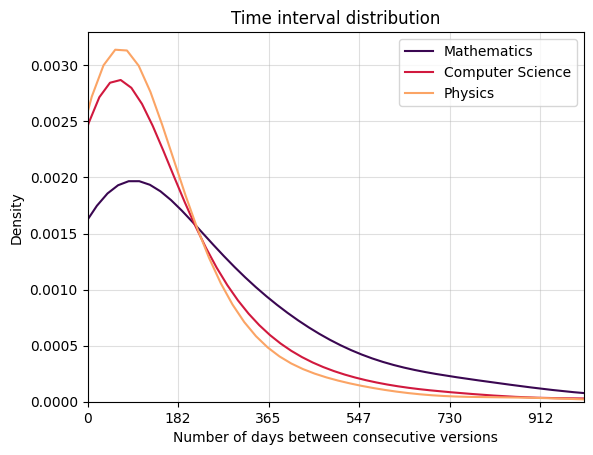

In [242]:
cs_dates = []
for d in cs_papers.delta_time:
    cs_dates.append(d.days)

math_dates = []
for d in math_papers.delta_time:
    math_dates.append(d.days)

phys_dates = []
for d in phys_papers.delta_time:
    phys_dates.append(d.days)
    
bw_adjust = 2


enmax_palette = ['#3A0751', '#D1193E', '#FBA465', '#F86E51']
sns.set_palette(palette=enmax_palette)


sns.kdeplot(math_dates, bw_adjust=bw_adjust, label='Mathematics')
sns.kdeplot(cs_dates, bw_adjust=bw_adjust, label='Computer Science')
sns.kdeplot(phys_dates, bw_adjust=bw_adjust, label='Physics')

plt.grid(True, alpha=0.4, linestyle='-')
plt.xlim([0, 1000])

x_ticks = np.append(plt.gca().get_xticks(), 365)
x_ticks = [0, 182, 365, 547, 730, 912]
# Set xtick locations to the values of the array `x_ticks`
plt.gca().set_xticks(x_ticks)

plt.title('Time interval distribution');
plt.xlabel('Number of days between consecutive versions')

plt.gca().legend()

In [773]:
def plot_kde(metric, bw_adjust=1, xlim=[-100, 100], xlabel=''):
    sns.kdeplot(data = cs_papers[metric], bw_adjust = bw_adjust, label='Computer Science')
    sns.kdeplot(data = math_papers[metric], bw_adjust = bw_adjust, label='Mathematics')
    sns.kdeplot(data = phys_papers[metric], bw_adjust = bw_adjust, label='Physics')
    plt.xlim(xlim)
    plt.xlabel(xlabel)
    plt.grid(True, alpha=0.8, linestyle='-')

    plt.gca().legend()

In [429]:
cs_union = cs_papers.loc[cs_papers.pages.notna()].merge(cs_papers.loc[cs_papers.tokens_cnt.notna()])

In [430]:
math_union = math_papers.loc[math_papers.pages.notna()].merge(math_papers.loc[math_papers.tokens_cnt.notna()])

In [431]:
phys_union = phys_papers.loc[phys_papers.pages.notna()].merge(phys_papers.loc[phys_papers.tokens_cnt.notna()])

In [433]:
cs_slope, cs_intercept, r, p, std_err = stats.linregress(cs_union.pages, cs_union.tokens_cnt)

In [434]:
math_slope, math_intercept, r, p, std_err = stats.linregress(math_union.pages, math_union.tokens_cnt)

In [435]:
phys_slope, phys_intercept, r, p, std_err = stats.linregress(phys_union.pages, phys_union.tokens_cnt)

In [447]:
cs_slope

204.26323077265764

In [437]:
math_slope

233.89166826860264

In [448]:
phys_slope

242.3273076342946

In [427]:
def myfunc(x):
    return slope * x + intercept

mymodel = list(map(myfunc, phys_papers.pages))

<AxesSubplot: xlabel='pages', ylabel='tokens_cnt'>

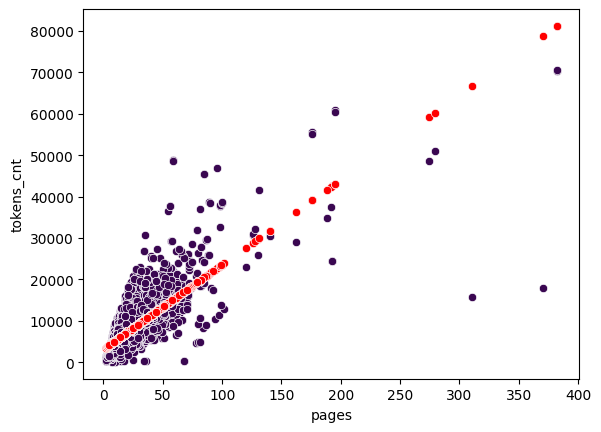

In [408]:
sns.scatterplot(data=cs_papers, x="pages", y="tokens_cnt")
sns.scatterplot(x=cs_papers.pages, y=mymodel, color='r')

In [640]:
kde_sp = scipy.stats.gaussian_kde(phys_papers.relative_added_words.dropna(), bw_method=0.25)

In [641]:
eval_points = np.linspace(0, 1, 1000)
y_sp = kde_sp.pdf(eval_points)

(array([0.67, 0.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ]),
 [Text(0.67, 0, '0.67'),
  Text(0.0, 0, '0.00'),
  Text(0.2, 0, '0.20'),
  Text(0.4, 0, '0.40'),
  Text(0.6000000000000001, 0, '0.60'),
  Text(0.8, 0, '0.80'),
  Text(1.0, 0, '1.00')])

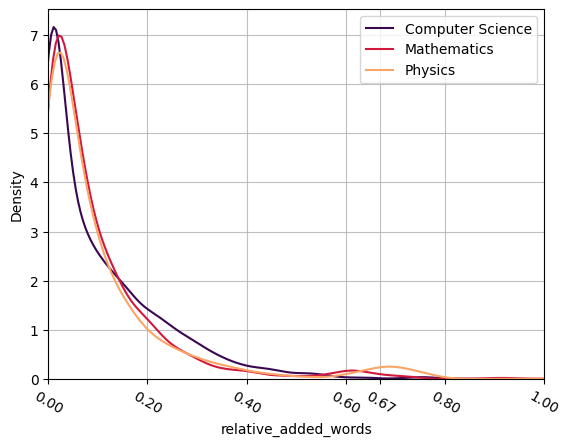

In [584]:
plot_kde('relative_added_words', bw_adjust = 1, xlim=[0, 1])
plt.gca().set_xticks(np.append(0.67, plt.gca().get_xticks()))
plt.xticks(fontsize=10, rotation=-30)

(array([0.75, 0.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ]),
 [Text(0.75, 0, '0.75'),
  Text(0.0, 0, '0.00'),
  Text(0.2, 0, '0.20'),
  Text(0.4, 0, '0.40'),
  Text(0.6000000000000001, 0, '0.60'),
  Text(0.8, 0, '0.80'),
  Text(1.0, 0, '1.00')])

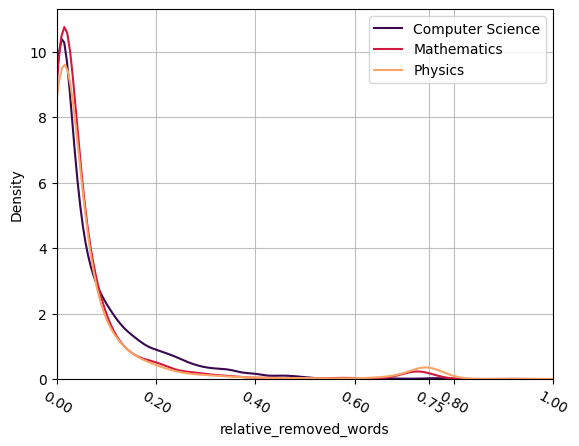

In [662]:
plot_kde('relative_removed_words', bw_adjust = 1, xlim=[0, 1])
plt.gca().set_xticks(np.append(0.75, plt.gca().get_xticks()))
plt.xticks(fontsize=10, rotation=-30)

In [699]:
kde_cs = scipy.stats.gaussian_kde(cs_papers.relative_removed_words.dropna(), bw_method=0.5)
kde_math = scipy.stats.gaussian_kde(math_papers.relative_removed_words.dropna(), bw_method=0.5)
kde_phys = scipy.stats.gaussian_kde(phys_papers.relative_removed_words.dropna(), bw_method=0.5)

eval_points = np.linspace(0, 1, 1000)

y_cs = kde_cs.pdf(eval_points)
y_math = kde_math.pdf(eval_points)
y_phys = kde_phys.pdf(eval_points)

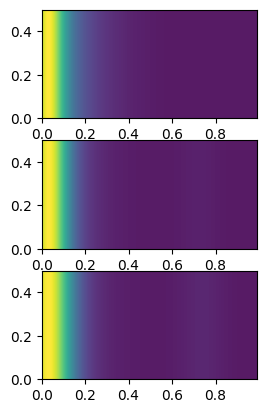

In [700]:
def func1(x, y, y_ref):
        l = []
        for xi in x[0]:
            l.append(y_ref[int(xi * 1000)])
        row = np.asarray(l)
        return np.tile(row, (2, 1))

# make these smaller to increase the resolution
dx, dy = 0.01, 0.5

x = np.arange(0, 1.0, dx)
y = np.arange(0, 1.0, dy)
X, Y = np.meshgrid(x, y)

extent = np.min(x), np.max(x), np.min(y), np.max(y)
fig = plt.figure(frameon=True)

Z_cs = func1(X, Y, y_cs)
Z_math = func1(X, Y, y_math)
Z_phys = func1(X, Y, y_phys)

plt.subplot(3, 1, 1)
im2 = plt.imshow(Z_cs, cmap=plt.cm.viridis, alpha=.9, interpolation='bilinear',
                 extent=extent)

plt.subplot(3, 1, 2)
im2 = plt.imshow(Z_math, cmap=plt.cm.viridis, alpha=.9, interpolation='bilinear',
                 extent=extent)

plt.subplot(3, 1, 3)
im2 = plt.imshow(Z_phys, cmap=plt.cm.viridis, alpha=.9, interpolation='bilinear',
                 extent=extent)

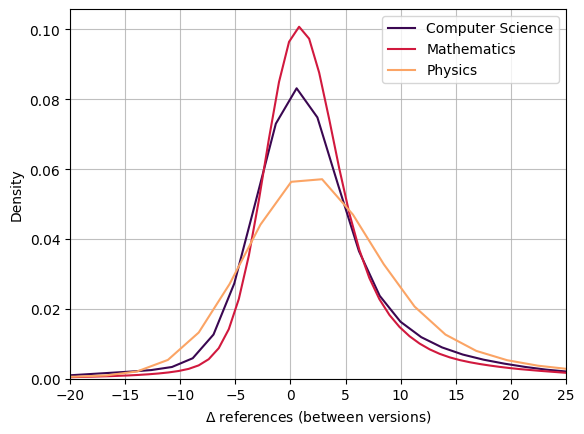

In [782]:
plot_kde('delta_ref_cnt', bw_adjust = 2, xlim=[-20, 25], xlabel='$\Delta$ references (between versions)')

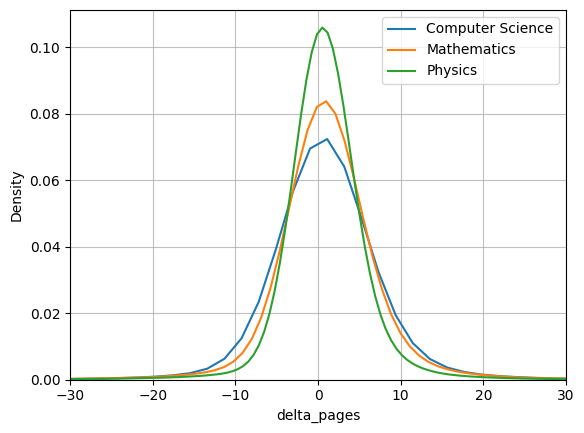

In [64]:
plot_kde('delta_pages', bw_adjust = 4, xlim=[-30, 30])

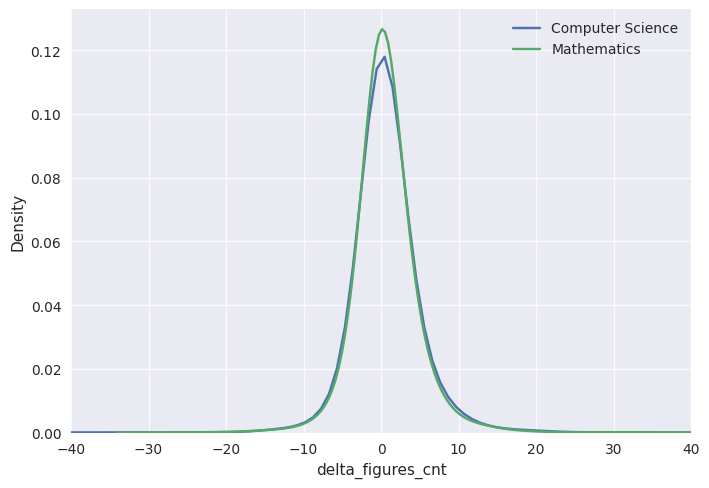

In [272]:
plot_kde('delta_figures_cnt', bw_adjust = 3, xlim=[-40, 40])

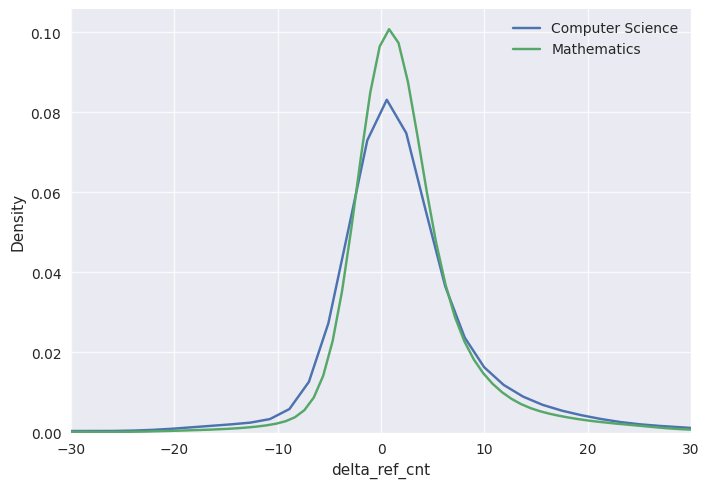

In [324]:
plot_kde('delta_ref_cnt', bw_adjust = 2, xlim=[-30, 30])

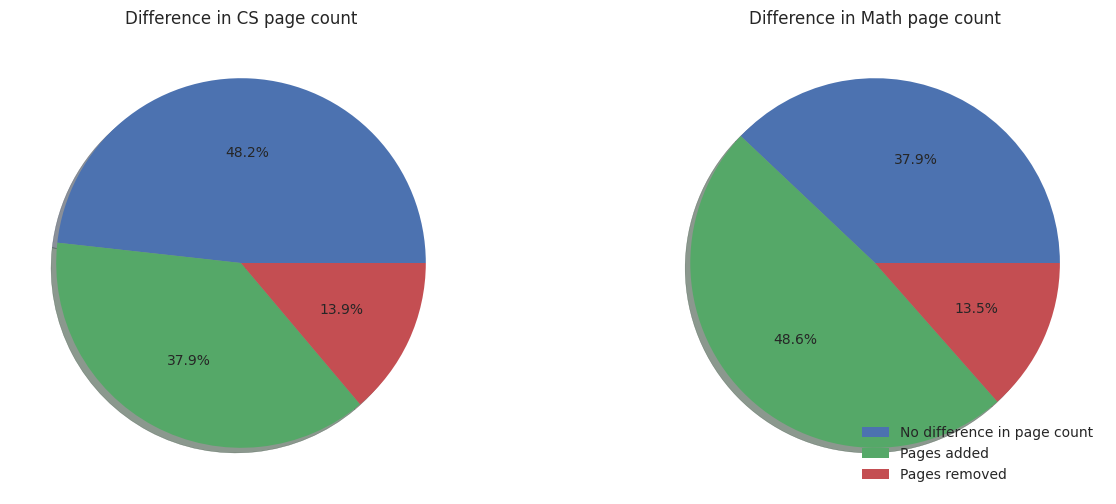

In [231]:
cs_added = cs_papers.loc[cs_papers.delta_pages > 0].id.count()
cs_subtracted = cs_papers.loc[cs_papers.delta_pages < 0].id.count()
cs_same = cs_papers.loc[cs_papers.delta_pages == 0].id.count()

math_added = math_papers.loc[math_papers.delta_pages > 0].id.count()
math_subtracted = math_papers.loc[math_papers.delta_pages < 0].id.count()
math_same = math_papers.loc[math_papers.delta_pages == 0].id.count()

cs_diffs = [cs_same, cs_added, cs_subtracted]
math_diffs = [math_same, math_added, math_subtracted]
labels = ['No difference in page count', 'Pages added', 'Pages removed']

def func(pct):
    return '{:1.1f}%'.format(pct)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.pie(cs_diffs, autopct=lambda pct: func(pct), shadow=True)
plt.title('Difference in CS page count')

plt.subplot(1, 2, 2)
plt.pie(math_diffs, autopct=lambda pct: func(pct), shadow=True)
plt.title('Difference in Math page count')

plt.legend(labels, loc=4)
plt.show() 
